In [1]:
import pandas as pd

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
old_df = pd.read_csv("../data/csv_oct09_24/sample_sep_1.csv")
old_df.columns

Index(['Unnamed: 0', 'responses_lo_1.2.institution_id',
       'responses_lo_1.2.class_id', 'responses_lo_1.2.student_id',
       'responses_lo_1.2.course_name', 'responses_lo_1.2.release',
       'responses_lo_1.2.book', 'responses_lo_1.2.response',
       'responses_lo_1.2.points_earned', 'responses_lo_1.2.completes_page',
       'responses_lo_1.2.dt_submitted', 'responses_lo_1.2.attempt',
       'responses_lo_1.2.id_p', 'responses_lo_1.2.chapter',
       'responses_lo_1.2.page', 'responses_lo_1.2.item_id',
       'responses_lo_1.2.item_type', 'responses_lo_1.2.lrn_type',
       'responses_lo_1.2.lrn_question_position',
       'responses_lo_1.2.lrn_question_reference', 'responses_lo_1.2.prompt',
       'responses_lo_1.2.lrn_option_0', 'responses_lo_1.2.lrn_option_1',
       'responses_lo_1.2.lrn_option_2', 'responses_lo_1.2.lrn_option_3',
       'responses_lo_1.2.lrn_option_4', 'responses_lo_1.2.lrn_option_5',
       'responses_lo_1.2.lrn_option_6', 'responses_lo_1.2.lrn_option_7',
 

In [3]:
new_df = pd.read_csv("../data/csv_oct15_24/responses_assessment_level2_3.1.csv")
new_df.columns

Index(['id_p', 'institution_id', 'class_id', 'course_name', 'release', 'book',
       'branch', 'student_id', 'item_id', 'item_type', 'chapter', 'page',
       'response', 'prompt', 'points_possible', 'points_earned',
       'dt_submitted', 'completes_page', 'attempt', 'user_agent',
       'lrn_session_id', 'lrn_response_id', 'lrn_activity_reference',
       'lrn_question_reference', 'lrn_question_position', 'lrn_type',
       'lrn_dt_started', 'lrn_dt_saved', 'lrn_status', 'lrn_response_json',
       'lrn_option_0', 'lrn_option_1', 'lrn_option_2', 'lrn_option_3',
       'lrn_option_4', 'lrn_option_5', 'lrn_option_6', 'lrn_option_7',
       'lrn_option_8', 'lrn_option_9', 'lrn_option_10', 'lrn_option_11',
       'chapter_num', 'page_num', 'level1', 'level2', 'level3', 'level4'],
      dtype='object')

In [4]:
len(new_df)

317633

In [5]:
import os
import rich

for p in os.listdir("../data/csv_oct15_24/"):
    df = pd.read_csv(f"../data/csv_oct15_24/{p}")
    rich.print(p, df["item_type"].unique())

responses_assessment_level2_3.2.csv ['learnosity']

responses_assessment_level2_3.3.csv ['code' 'learnosity']

responses_assessment_level2_1.1.csv ['learnosity']

responses_assessment_level2_1.3.csv ['learnosity']

responses_assessment_level2_3.1.csv ['learnosity' 'code']

responses_assessment_level2_1.2.csv ['learnosity' 'code']

responses_assessment_level2_3.4.csv ['code' 'learnosity']

responses_assessment_level2_3.5.csv ['learnosity']

responses_assessment_level2_3.6.csv ['learnosity']

responses_assessment_level2_2.1.csv ['learnosity']

responses_assessment_level2_2.2.csv ['learnosity' 'code']

responses_assessment_level2_2.3.csv ['code' 'learnosity']

responses_assessment_level2_4.1.csv ['learnosity' 'code']

responses_assessment_level2_4.2.csv ['learnosity' 'code']

responses_assessment_level2_4.3.csv ['learnosity' 'code']

In [6]:
new_df["item_type"].unique()

array(['learnosity', 'code'], dtype=object)

In [7]:
deduped_new_df = new_df.drop_duplicates()

In [8]:
import pandas as pd
import re
import rich
import os

from pyBKT.models import Model


def _extract_chapter(path: str) -> str:
    """
    Extract the chapter name from the path
    """
    # The path is in the format of responses_assessment_level2_1.1.csv
    # We want to extract the chapter number from the file name, i.e. 1.1 in this case
    chapter_pattern = re.compile(r".*responses_assessment_level2_(\d+\.\d+)\.csv")

    # Find column from data.columns that match the above pattern and extract out the chapter
    match = chapter_pattern.match(path)
    chapter = match.group(1)
    return chapter


def process_data(path: str, output_folder: str) -> dict[str, float]:
    """
    Process the data from the file specified by the path.
    Return the coefs learned from the model as a dict.
    """

    data = pd.read_csv(path, index_col=0, low_memory=False)
    chapter = _extract_chapter(path)

    rich.print(f"[yellow bold]Processing chapter: [/yellow bold]{chapter}")

    if len(data) == 0:
        rich.print("[red bold]No data found, skipped[/red bold]")
        return

    # Define the columns we're interested in
    points_earned_col = "points_earned"
    submitted_col = "dt_submitted"
    student_id_col = "student_id"
    item_id_col = "item_id"
    type_col = "item_type"

    # Run some transformations to get the data into the correct format
    # Drop nan values in the points_earned column
    data = data.dropna(subset=[points_earned_col])

    # Ensure the dt_submitted column is in datetime format
    data[submitted_col] = pd.to_datetime(data[submitted_col])

    # drop duplicate rows
    data = data.drop_duplicates()

    # Sort the data by student, item_id and submission time to create order_id
    data = data.sort_values(by=[student_id_col, item_id_col, submitted_col])

    # Process code submissions differently from learnosity
    def process_student_submissions(group):
        # Do not process if the question type is not `code`
        if group[type_col].iloc[0] != "code":
            return group

        # Always keep first submission
        result = group.iloc[[0]]

        # If first submission was incorrect and there exists a correct submission
        if (
            group[points_earned_col].iloc[0] == 0
            and (group[points_earned_col] > 0).any()
        ):
            # Find first correct submission
            first_correct = group[group[points_earned_col] > 0].iloc[0]
            result = pd.concat([result, first_correct.to_frame().T])

        return result

    # Apply the processing logic to each student-question combination
    processed_data = data.groupby(
        [student_id_col, item_id_col], group_keys=False
    ).apply(process_student_submissions)

    # Now sort by student and submission time to create final order_id
    processed_data = processed_data.sort_values(by=[student_id_col, submitted_col])

    # Create order_id (sequence number of observations per student)
    processed_data["order_id"] = processed_data.groupby(student_id_col).cumcount() + 1

    # Rename columns to match pyBKT expected format
    bkt_data = processed_data.rename(
        columns={
            student_id_col: "user_id",
            points_earned_col: "correct",
        }
    )

    # Assign a skill name (you can change this if you're tracking multiple skills)
    bkt_data["skill_name"] = (
        0  # If you're tracking only one skill, this can be constant
    )

    bkt_data = bkt_data.reset_index()

    # Drop unnecessary columns
    bkt_data = bkt_data[["user_id", "order_id", "correct", "skill_name"]]

    if len(bkt_data) == 0:
        rich.print("[red bold]No BKT data built, skipped[/red bold]")
        return

    # Fit the model
    model = Model(seed=42, num_fits=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        model.fit(data=bkt_data)

        # Generate predictions for each attempt
        predictions = model.predict(data=bkt_data)

    # Get the final predictions after all attempts for each student
    final_predictions = predictions.groupby("user_id").last()[
        ["correct_predictions", "state_predictions"]
    ]

    # Rename the aggregated columns
    final_predictions = final_predictions.rename(
        columns={
            "state_predictions": "final_state_predictions",
            "correct_predictions": "final_correct_predictions",
        }
    )

    # Create the folder if it doesn't exist using python
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    final_predictions.to_csv(f"{output_folder}/predictions_{chapter}.csv")

    # Process the coefficients
    coef = model.coef_["0"]
    return {
        "chapter": chapter,
        "prior": float(coef["prior"]),
        "learns": float(coef["learns"][0]),
        "guesses": float(coef["guesses"][0]),
        "slips": float(coef["slips"][0]),
    }

In [9]:
path = "../data/csv_oct15_24/responses_assessment_level2_2.2.csv"

data = pd.read_csv(path, index_col=0, low_memory=False)
chapter = _extract_chapter(path)

rich.print(f"[yellow bold]Processing chapter: [/yellow bold]{chapter}")

if len(data) == 0:
    rich.print("[red bold]No data found, skipped[/red bold]")

# Define the columns we're interested in
points_earned_col = "points_earned"
submitted_col = "dt_submitted"
student_id_col = "student_id"
item_id_col = "item_id"
type_col = "item_type"

# Run some transformations to get the data into the correct format
# Drop nan values in the points_earned column
data = data.dropna(subset=[points_earned_col])

# Ensure the dt_submitted column is in datetime format
data[submitted_col] = pd.to_datetime(data[submitted_col])

# drop duplicate rows
data = data.drop_duplicates()

# Sort the data by student, item_id and submission time to create order_id
data = data.sort_values(by=[student_id_col, item_id_col, submitted_col])


# Process code submissions differently from learnosity
def process_student_submissions(group):
    # Do not process if the question type is not `code`
    if group[type_col].iloc[0] != "code":
        return group

    # Always keep first submission
    result = group.iloc[[0]]

    # If first submission was incorrect and there exists a correct submission
    if group[points_earned_col].iloc[0] == 0 and (group[points_earned_col] > 0).any():
        # Find first correct submission
        first_correct = group[group[points_earned_col] > 0].iloc[0]
        result = pd.concat([result, first_correct.to_frame().T])

    return result


# Apply the processing logic to each student-question combination
processed_data = data.groupby([student_id_col, item_id_col], group_keys=False).apply(
    process_student_submissions
)

# Now sort by student and submission time to create final order_id
processed_data = processed_data.sort_values(by=[student_id_col, submitted_col])

# Create order_id (sequence number of observations per student)
processed_data["order_id"] = processed_data.groupby(student_id_col).cumcount() + 1

# Rename columns to match pyBKT expected format
bkt_data = processed_data.rename(
    columns={
        student_id_col: "user_id",
        points_earned_col: "correct",
    }
)

# Assign a skill name (you can change this if you're tracking multiple skills)
bkt_data["skill_name"] = 0  # If you're tracking only one skill, this can be constant

bkt_data = bkt_data.reset_index()

# Drop unnecessary columns
bkt_data = bkt_data[["user_id", "order_id", "correct", "skill_name"]]

Processing chapter: 2.2

In [10]:
data[data["item_type"] == "code"]

,institution_id,class_id,course_name,release,book,branch,student_id,item_id,item_type,chapter,...,lrn_option_8,lrn_option_9,lrn_option_10,lrn_option_11,chapter_num,page_num,level1,level2,level3,level4
id_p,,,,,,,,,,,,,,,,,,,,,
ch4-10 1,f390f0ca-5552-4d59-85e7-1bdede366fbe,e809a739-a6f8-458f-a6c9-960e81b74012,UCLATALL/czi-stats-course,v5.2,High School / Statistics and Data Science I (AB),release/v5.2,0025760d-ecfc-4578-9c7a-871a5a74391c,ch4-10,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.3,2.2.3.2
ch4-10 1,f390f0ca-5552-4d59-85e7-1bdede366fbe,e809a739-a6f8-458f-a6c9-960e81b74012,UCLATALL/czi-stats-course,v5.2,High School / Statistics and Data Science I (AB),release/v5.2,0025760d-ecfc-4578-9c7a-871a5a74391c,ch4-10,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.2,2.2.2.2
ch4-10 1,f390f0ca-5552-4d59-85e7-1bdede366fbe,e809a739-a6f8-458f-a6c9-960e81b74012,UCLATALL/czi-stats-course,v5.2,High School / Statistics and Data Science I (AB),release/v5.2,0025760d-ecfc-4578-9c7a-871a5a74391c,ch4-10,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.3,2.2.3.2
ch4-10 1,f390f0ca-5552-4d59-85e7-1bdede366fbe,e809a739-a6f8-458f-a6c9-960e81b74012,UCLATALL/czi-stats-course,v5.2,High School / Statistics and Data Science I (AB),release/v5.2,0025760d-ecfc-4578-9c7a-871a5a74391c,ch4-10,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.2,2.2.2.2
ch4-11 1,f390f0ca-5552-4d59-85e7-1bdede366fbe,e809a739-a6f8-458f-a6c9-960e81b74012,UCLATALL/czi-stats-course,v5.2,High School / Statistics and Data Science I (AB),release/v5.2,0025760d-ecfc-4578-9c7a-871a5a74391c,ch4-11,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.2,2.2.2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ch4-5 1,6496506d-b49b-4477-9435-ddea44a88008,926fc0d4-b7c4-4bb0-a6d7-3f0ca17c0ce2,UCLATALL/czi-stats-course,v5.5,High School / Statistics and Data Science I (AB),release/v5.5,ffe75b53-b7b6-4488-85f0-f60112e1dd43,ch4-5,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.3,2.2.3.3
ch4-5 1,6496506d-b49b-4477-9435-ddea44a88008,926fc0d4-b7c4-4bb0-a6d7-3f0ca17c0ce2,UCLATALL/czi-stats-course,v5.5,High School / Statistics and Data Science I (AB),release/v5.5,ffe75b53-b7b6-4488-85f0-f60112e1dd43,ch4-5,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.3,2.2.3.3
ch4-9 1,6496506d-b49b-4477-9435-ddea44a88008,926fc0d4-b7c4-4bb0-a6d7-3f0ca17c0ce2,UCLATALL/czi-stats-course,v5.5,High School / Statistics and Data Science I (AB),release/v5.5,ffe75b53-b7b6-4488-85f0-f60112e1dd43,ch4-9,code,Chapter 4 - Explaining Variation,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2.20000,2.2.3,2.2.3.2


In [11]:
# show at most 100 rows
pd.set_option("display.max_rows", 100)

In [12]:
data[data["student_id"] == "ffe75b53-b7b6-4488-85f0-f60112e1dd43"][
    ["item_id", "points_earned", "dt_submitted", "item_type"]
].drop_duplicates().sort_values(by="dt_submitted")

,item_id,points_earned,dt_submitted,item_type
id_p,,,,
ch2-20 1,ch2-20,0.00000,2024-03-18 16:40:38.000000,code
ch2-20 1,ch2-20,0.00000,2024-03-18 16:41:14.000000,code
ch2-20 1,ch2-20,0.00000,2024-03-18 16:41:45.000000,code
ch2-20 1,ch2-20,0.00000,2024-03-18 16:42:37.000000,code
Ch2_Structure_7 1,Ch2_Structure_7,1.00000,2024-03-18 16:44:14.379441,learnosity
A2_Review1_10 1,A2_Review1_10,1.00000,2024-03-21 16:44:33.961950,learnosity
A2_Review2_12 1,A2_Review2_12,0.00000,2024-03-21 17:05:55.607949,learnosity
A2_Review2_14 1,A2_Review2_14,1.00000,2024-03-21 17:13:37.446208,learnosity
Ch3_Concept_1 2,Ch3_Concept_1,0.00000,2024-03-22 16:50:21.868564,learnosity


In [13]:
processed_data[processed_data["student_id"] == "ffe75b53-b7b6-4488-85f0-f60112e1dd43"][
    ["item_id", "points_earned", "dt_submitted", "item_type", "order_id"]
]

,item_id,points_earned,dt_submitted,item_type,order_id
ch2-20 1,ch2-20,0.00000,2024-03-18 16:40:38,code,1
Ch2_Structure_7 1,Ch2_Structure_7,1.00000,2024-03-18 16:44:14.379441,learnosity,2
A2_Review1_10 1,A2_Review1_10,1.00000,2024-03-21 16:44:33.961950,learnosity,3
A2_Review2_12 1,A2_Review2_12,0.00000,2024-03-21 17:05:55.607949,learnosity,4
A2_Review2_14 1,A2_Review2_14,1.00000,2024-03-21 17:13:37.446208,learnosity,5
Ch3_Concept_1 2,Ch3_Concept_1,0.00000,2024-03-22 16:50:21.868564,learnosity,6
Ch3_Concept_5 1,Ch3_Concept_5,0.00000,2024-03-22 16:55:01.181651,learnosity,7
Ch3_Concept_10 1,Ch3_Concept_10,1.00000,2024-03-22 16:55:14.829937,learnosity,8
Ch3_Concept_6 1,Ch3_Concept_6,1.00000,2024-03-22 17:02:13.461422,learnosity,9
Ch3_Concept_2 1,Ch3_Concept_2,1.00000,2024-03-25 16:41:56.488562,learnosity,10


In [14]:
bkt_data[bkt_data["user_id"] == "0281beb5-c599-4da7-865f-af93088acfd9"]

,user_id,order_id,correct,skill_name
1214,0281beb5-c599-4da7-865f-af93088acfd9,1,1.00000,0
1215,0281beb5-c599-4da7-865f-af93088acfd9,2,1.00000,0
1216,0281beb5-c599-4da7-865f-af93088acfd9,3,0.00000,0
1217,0281beb5-c599-4da7-865f-af93088acfd9,4,1.00000,0
1218,0281beb5-c599-4da7-865f-af93088acfd9,5,1.00000,0
1219,0281beb5-c599-4da7-865f-af93088acfd9,6,1.00000,0
1220,0281beb5-c599-4da7-865f-af93088acfd9,7,1.00000,0
1221,0281beb5-c599-4da7-865f-af93088acfd9,8,1.00000,0
1222,0281beb5-c599-4da7-865f-af93088acfd9,9,1.00000,0
1223,0281beb5-c599-4da7-865f-af93088acfd9,10,1.00000,0


In [15]:
data.columns

Index(['institution_id', 'class_id', 'course_name', 'release', 'book',
       'branch', 'student_id', 'item_id', 'item_type', 'chapter', 'page',
       'response', 'prompt', 'points_possible', 'points_earned',
       'dt_submitted', 'completes_page', 'attempt', 'user_agent',
       'lrn_session_id', 'lrn_response_id', 'lrn_activity_reference',
       'lrn_question_reference', 'lrn_question_position', 'lrn_type',
       'lrn_dt_started', 'lrn_dt_saved', 'lrn_status', 'lrn_response_json',
       'lrn_option_0', 'lrn_option_1', 'lrn_option_2', 'lrn_option_3',
       'lrn_option_4', 'lrn_option_5', 'lrn_option_6', 'lrn_option_7',
       'lrn_option_8', 'lrn_option_9', 'lrn_option_10', 'lrn_option_11',
       'chapter_num', 'page_num', 'level1', 'level2', 'level3', 'level4'],
      dtype='object')

In [16]:
student_data = data[data["student_id"] == "0281beb5-c599-4da7-865f-af93088acfd9"][
    ["student_id", "points_earned", "dt_submitted"]
]
student_data

,student_id,points_earned,dt_submitted
id_p,,,
A2_Review1_10 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-09-18 16:56:38.268442
A2_Review2_12 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-09-18 17:38:15.564269
A2_Review2_14 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-09-18 17:41:05.701307
A3_Review1_01 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:47:42.757132
A3_Review1_02 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-10-13 16:48:00.229826
A3_Review1_03 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:49:07.054871
A3_Review1_04 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:49:24.773282
A3_Review1_05 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:50:25.316203
A3_Review1_06 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-10-13 16:51:38.015147


In [17]:
student_data.drop_duplicates()

,student_id,points_earned,dt_submitted
id_p,,,
A2_Review1_10 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-09-18 16:56:38.268442
A2_Review2_12 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-09-18 17:38:15.564269
A2_Review2_14 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-09-18 17:41:05.701307
A3_Review1_01 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:47:42.757132
A3_Review1_02 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-10-13 16:48:00.229826
A3_Review1_03 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:49:07.054871
A3_Review1_04 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:49:24.773282
A3_Review1_05 1,0281beb5-c599-4da7-865f-af93088acfd9,0.00000,2023-10-13 16:50:25.316203
A3_Review1_06 1,0281beb5-c599-4da7-865f-af93088acfd9,1.00000,2023-10-13 16:51:38.015147


In [18]:
model = Model(seed=42, num_fits=1)

In [19]:
import warnings

# Silence RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

model.fit(data=bkt_data)

In [20]:
prediction_df = model.predict(data=bkt_data)

In [21]:
pd.set_option("display.max_rows", 50)

prediction_df[prediction_df["user_id"] == "0281beb5-c599-4da7-865f-af93088acfd9"]

,user_id,order_id,correct,skill_name,correct_predictions,state_predictions
1214,0281beb5-c599-4da7-865f-af93088acfd9,1,1,0,0.60058,0.59391
1215,0281beb5-c599-4da7-865f-af93088acfd9,2,1,0,0.64895,0.73359
1216,0281beb5-c599-4da7-865f-af93088acfd9,3,0,0,0.68520,0.83826
1217,0281beb5-c599-4da7-865f-af93088acfd9,4,1,0,0.63380,0.68984
1218,0281beb5-c599-4da7-865f-af93088acfd9,5,1,0,0.67444,0.80719
...,...,...,...,...,...,...
1299,0281beb5-c599-4da7-865f-af93088acfd9,86,0,0,0.74090,0.99912
1300,0281beb5-c599-4da7-865f-af93088acfd9,87,1,0,0.74050,0.99795
1301,0281beb5-c599-4da7-865f-af93088acfd9,88,0,0,0.74083,0.99891
1302,0281beb5-c599-4da7-865f-af93088acfd9,89,1,0,0.74033,0.99747


In [42]:
import numpy as np
from sklearn.metrics import roc_auc_score

# NOTE: the following way to manually compute metrics is validated by comparing with the metrics computed by the `pyBKT` package.

# Group by user_id and compute metrics for each group
metrics_by_student = {}
for student, student_df in prediction_df.groupby("user_id"):
    # Vectorized accuracy calculation
    predictions = (student_df["correct_predictions"] > 0.5).astype(int)
    accuracy = (student_df["correct"] == predictions).mean()

    # Vectorized AUC calculation
    unique_classes = student_df["correct"].nunique()
    auc = (
        roc_auc_score(student_df["correct"], student_df["correct_predictions"])
        if unique_classes > 1
        else 0.5
    )

    # Vectorized RMSE calculation
    rmse = np.sqrt(
        ((student_df["correct"] - student_df["correct_predictions"]) ** 2).mean()
    )

    metrics_by_student[student] = {
        "accuracy": accuracy,
        "auc": auc,
        "rmse": rmse,
    }

# Compute the average of the metrics
average_accuracy = np.mean(
    [metric["accuracy"] for metric in metrics_by_student.values()]
)
average_auc = np.mean([metric["auc"] for metric in metrics_by_student.values()])
average_rmse = np.mean([metric["rmse"] for metric in metrics_by_student.values()])

average_accuracy, average_auc, average_rmse

(0.6608436936881462, 0.40693204539017547, 0.46414101000361496)

In [52]:
n_attempts_by_student = {
    student: len(student_df) for student, student_df in prediction_df.groupby("user_id")
}

# Some percentiles of the number of attempts
for p in [25, 50, 90, 95, 99]:
    n_students_above = sum(
        1
        for n in n_attempts_by_student.values()
        if n >= np.percentile(list(n_attempts_by_student.values()), p)
    )
    rich.print(
        f"The {p}th percentile of the number of attempts is {np.percentile(list(n_attempts_by_student.values()), p)}, with {n_students_above} students above the threshold."
    )

The 25th percentile of the number of attempts is 25.0, with 1502 students above the threshold.

The 50th percentile of the number of attempts is 71.0, with 1001 students above the threshold.

The 90th percentile of the number of attempts is 127.0, with 203 students above the threshold.

The 95th percentile of the number of attempts is 133.0, with 106 students above the threshold.

The 99th percentile of the number of attempts is 142.02999999999997, with 20 students above the threshold.

In [50]:
len(n_attempts_by_student)

1998

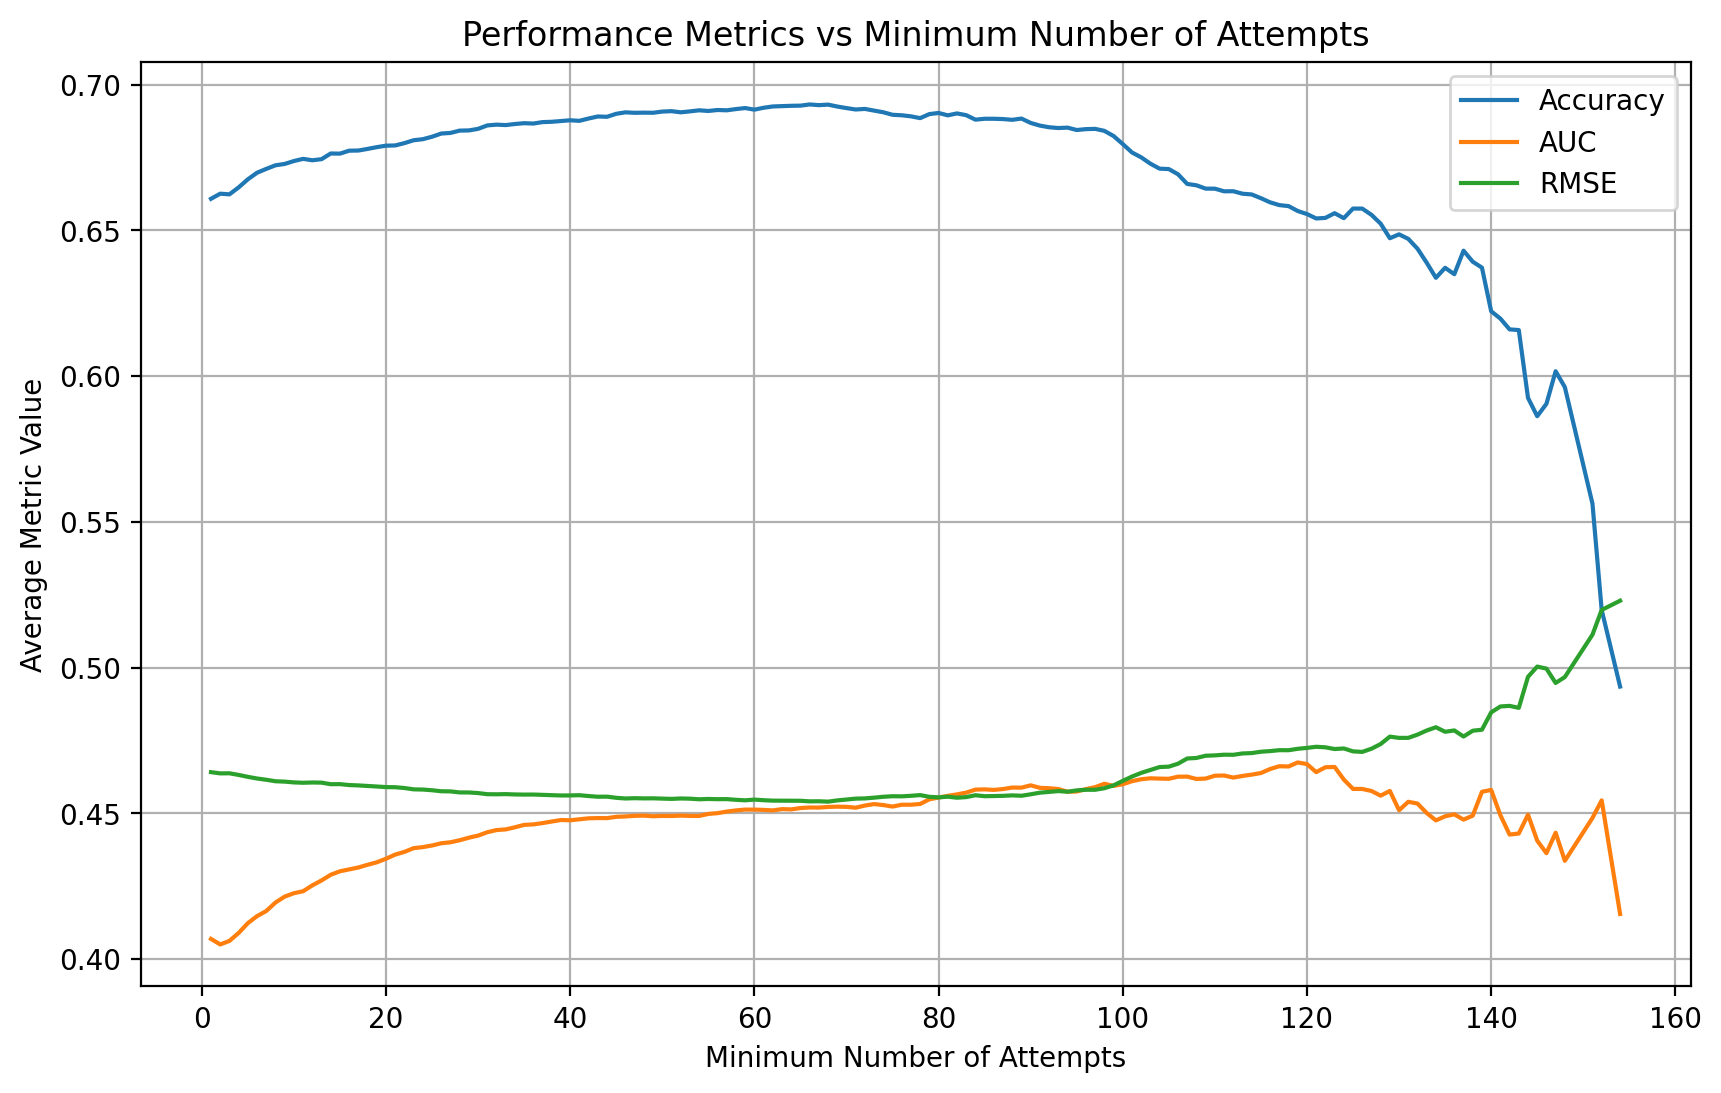

In [49]:
import matplotlib.pyplot as plt

# Enable retina display mode for higher resolution plots
%config InlineBackend.figure_format = 'retina'


# Get sorted unique attempt counts
attempt_counts = sorted(n_attempts_by_student.values())

# Initialize lists to store metrics
x_attempts = []
y_accuracy = []
y_auc = []
y_rmse = []

# For each attempt count threshold
for n_attempts in attempt_counts:
    # Get students with at least this many attempts
    qualified_students = [
        student
        for student, count in n_attempts_by_student.items()
        if count >= n_attempts
    ]

    if len(qualified_students) > 0:
        # Calculate average metrics for qualified students
        avg_accuracy = np.mean(
            [metrics_by_student[student]["accuracy"] for student in qualified_students]
        )
        avg_auc = np.mean(
            [metrics_by_student[student]["auc"] for student in qualified_students]
        )
        avg_rmse = np.mean(
            [metrics_by_student[student]["rmse"] for student in qualified_students]
        )

        x_attempts.append(n_attempts)
        y_accuracy.append(avg_accuracy)
        y_auc.append(avg_auc)
        y_rmse.append(avg_rmse)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_attempts, y_accuracy, label="Accuracy")
plt.plot(x_attempts, y_auc, label="AUC")
plt.plot(x_attempts, y_rmse, label="RMSE")
plt.xlabel("Minimum Number of Attempts")
plt.ylabel("Average Metric Value")
plt.title("Performance Metrics vs Minimum Number of Attempts")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
model.coef_

{'0': {'prior': np.float64(0.2596580956384623),
  'learns': array([0.00368407]),
  'guesses': array([0.36249751]),
  'slips': array([0.17124273]),
  'forgets': array([0.])}}

In [17]:
coefs = []

coef = model.coef_["0"]
coef

{'prior': np.float64(0.259701541449756),
 'learns': array([0.00368414]),
 'guesses': array([0.36248229]),
 'slips': array([0.17126229]),
 'forgets': array([0.])}

In [18]:
float(coef["prior"])

0.259701541449756

In [20]:
coef["learns"][0]

np.float64(0.003684136079713055)

In [21]:
float(coef["learns"][0])

0.003684136079713055

In [23]:
{
    "chapter": chapter,
    "prior": float(coef["prior"]),
    "learns": float(coef["learns"][0]),
    "guesses": float(coef["guesses"][0]),
    "slips": float(coef["slips"][0]),
}

{'chapter': '3.2',
 'prior': 0.259701541449756,
 'learns': 0.003684136079713055,
 'guesses': 0.3624822871232267,
 'slips': 0.17126229068293614}

In [26]:
coef_df = pd.DataFrame(
    [
        {
            "chapter": chapter,
            "prior": float(coef["prior"]),
            "learns": float(coef["learns"][0]),
            "guesses": float(coef["guesses"][0]),
            "slips": float(coef["slips"][0]),
        },
        {
            "chapter": "1.1",
            "prior": float(coef["prior"]),
            "learns": float(coef["learns"][0]),
            "guesses": float(coef["guesses"][0]),
            "slips": float(coef["slips"][0]),
        },
        {
            "chapter": "1.2",
            "prior": float(coef["prior"]),
            "learns": float(coef["learns"][0]),
            "guesses": float(coef["guesses"][0]),
            "slips": float(coef["slips"][0]),
        },
    ]
)

In [27]:
coef_df.sort_values(by="chapter")

,chapter,prior,learns,guesses,slips
1,1.1,0.25970,0.00368,0.36248,0.17126
2,1.2,0.25970,0.00368,0.36248,0.17126
0,3.2,0.25970,0.00368,0.36248,0.17126
